### First Machine Learning model
* Split test and train data
* Get some insights
* Train the model

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#### Load data

In [2]:
avc = pd.read_parquet("../data/processed/avc-cuiaba.parquet")

#### Creating column year to stratify the dataset

In [3]:
avc["year"] = avc.data.dt.year

#### Split dataset in train and test

In [4]:
strat_train_set, strat_test_set = train_test_split(
    avc, test_size=0.2, stratify=avc["year"], random_state=42
)

In [5]:
# Look with the proportion is the same for all the years as expected
strat_test_set["year"].value_counts() / len(strat_test_set)

2016    0.336364
2017    0.331818
2018    0.331818
Name: year, dtype: float64

#### Stratfied vs random sampling

In [203]:
def income_cat_proportions(data):
    return data["year"].value_counts() / len(data)

train_set, test_set = train_test_split(avc, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(avc),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Year"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Year,,,,,
2016,33.39,33.64,35.91,0.73,7.53
2017,33.30,33.18,31.36,-0.36,-5.82
2018,33.30,33.18,32.73,-0.36,-1.73


#### Delete year column, not necessary anymore

In [204]:
strat_test_set = strat_test_set.drop(columns="year")
strat_train_set = strat_train_set.drop(columns="year")

#### Exploratory data analysis

In [205]:
avc = strat_train_set.copy()

#### Looking for correlations

In [206]:
corr_matrix = avc.corr()

/tmp/ipykernel_207/2997149164.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = avc.corr()


In [207]:
corr_matrix["LOAVC"].sort_values(ascending=False)

LOAVC        1.000000
LAG0         0.480254
UR           0.066488
PRESS       -0.016176
TMAX        -0.032297
so2_ugm3    -0.043900
o3_ppb      -0.049242
pm25_ugm3   -0.050496
DS          -0.051674
no2_ppb     -0.060922
co_ppb      -0.064867
Name: LOAVC, dtype: float64

In [208]:
corr_matrix["LAG0"].sort_values(ascending=False)

LAG0         1.000000
LOAVC        0.480254
so2_ugm3     0.081935
TMAX         0.048068
no2_ppb      0.045785
co_ppb       0.008848
pm25_ugm3    0.000724
PRESS       -0.006630
o3_ppb      -0.008346
UR          -0.026924
DS          -0.166912
Name: LAG0, dtype: float64

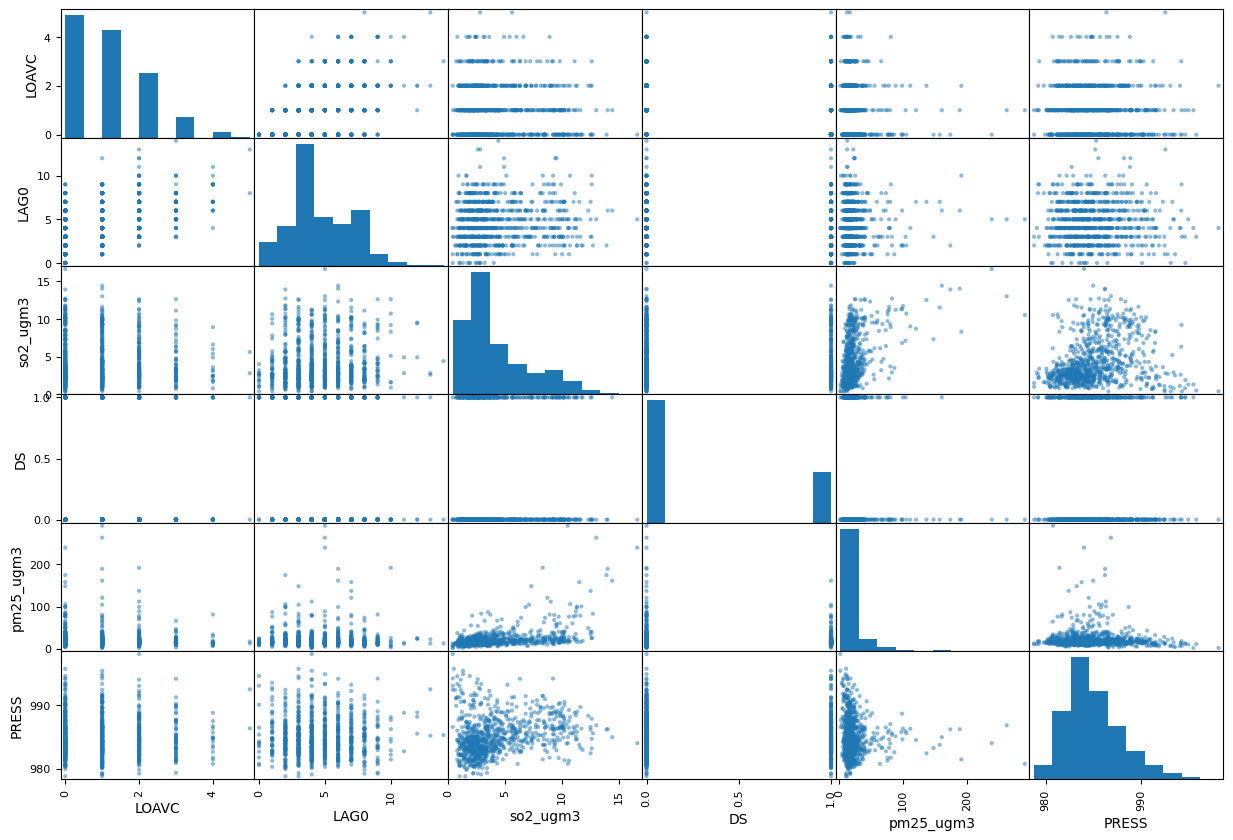

In [209]:
# Generate correlation plot with pandas
from pandas.plotting import scatter_matrix, hist_frame

columns = ["LOAVC", "LAG0", "so2_ugm3", \
           "DS", "pm25_ugm3", "PRESS"]

scatter_matrix(avc[columns], figsize=(15, 10))
plt.show()

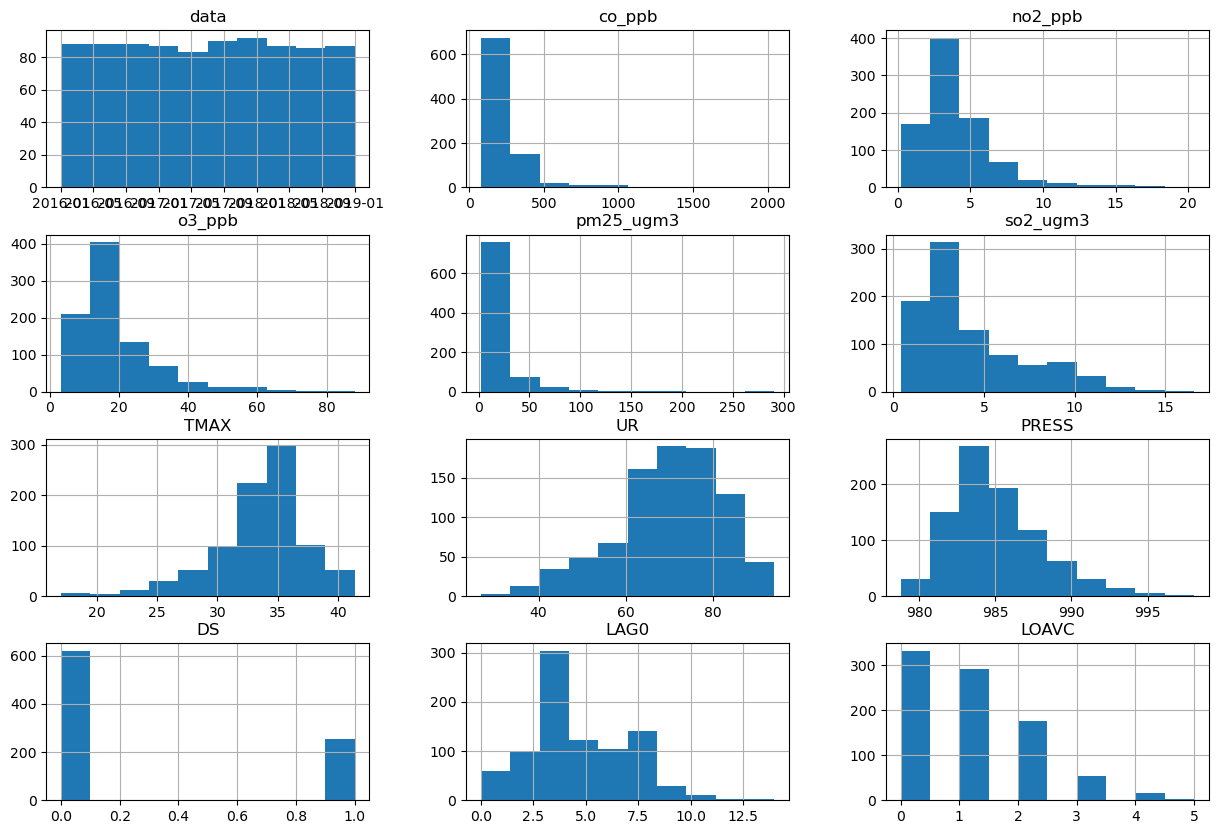

In [210]:
hist_frame(avc, figsize=(15,10))
plt.show()

In [211]:
avc = strat_train_set.drop(columns=["LOAVC", "LAG0", "DS", "data"])
avc_labels = strat_train_set.LOAVC.copy()

#### Making the pipeline

In [212]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

avc.columns

pipe = Pipeline([
    ("log", FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ("standardize", StandardScaler())
])

preprocessing = ColumnTransformer([
    ("log", pipe, avc.columns.values)
])

In [213]:
avc_processed = preprocessing.fit_transform(avc)
avc_processed[:2]

array([[ 0.42879154,  0.20096405,  0.95104459, -0.2770049 , -0.22740755,
         0.87635636, -0.70629691, -1.21141211],
       [-1.23491722, -0.11008021, -0.91325593, -1.34157893,  0.34651024,
        -0.76562905, -0.4511372 ,  1.91760423]])

In [214]:
avc_processed = pd.DataFrame(
    avc_processed, 
    columns=preprocessing.get_feature_names_out(), 
    index=avc.index
    )

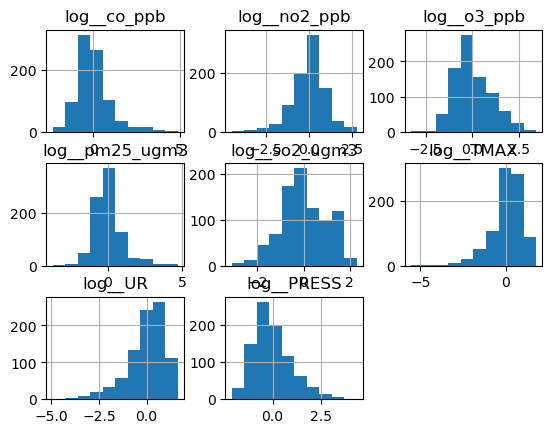

In [215]:
hist_frame(avc_processed)
plt.show()

#### Train and Evaluate on the Training Set

In [216]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Linear Regression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(avc, avc_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  array(['co_ppb', 'no2_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3', 'TMAX',
       'UR', 'PRESS'], dtype=object))])),
                ('linearregression', LinearRegression())])

In [217]:
avc_predict = lin_reg.predict(avc)
avc_predict[:3].round()

array([1., 1., 1.])

In [218]:
avc_labels[:3]

/tmp/ipykernel_207/4090567344.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  avc_labels[:3]


672    3
874    0
56     1
Name: LOAVC, dtype: int64

In [219]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(avc_labels, avc_predict)
print(f"The error is: {lin_rmse.round(2)}")

The error is: 1.02


##### Decision Tree Regressor

In [220]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(avc, avc_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  array(['co_ppb', 'no2_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3', 'TMAX',
       'UR', 'PRESS'], dtype=object))])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [221]:
avc_predict = tree_reg.predict(avc)
tree_rmse = mean_squared_error(
    avc_labels, 
    avc_predict, 
    squared=False
    )

print(f"The error is: {tree_rmse}, is this possible?")

The error is: 0.0, is this possible?


##### Making cross validation

In [224]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(
    tree_reg, 
    avc, 
    avc_labels, 
    scoring="neg_root_mean_squared_error",
    cv=10
    )

pd.Series(tree_rmses).describe()

count    10.000000
mean      1.442817
std       0.092414
min       1.308680
25%       1.362520
50%       1.444020
75%       1.504536
max       1.584728
dtype: float64

##### Random Forest Regressor

In [226]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, avc, avc_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

pd.Series(forest_rmses).describe()

count    10.000000
mean      1.055841
std       0.095098
min       0.928902
25%       0.974316
50%       1.038879
75%       1.130120
max       1.189403
dtype: float64